### First sketches

#### General imports and definitions

In [1]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

import matplotlib
import matplotlib.pyplot as plt
plt.rc('font', size=16) 

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.9.1


Set seed for reproducibility

In [2]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

#### Load and clean the dataset

In [3]:
path = os.getcwd()
# Load the .npy file
X = np.load(path+r'\training\x_train.npy').astype(np.float16)
y = np.load(path+r'\training\y_train.npy').astype(np.int8)

# Note as sequences are already built, with window 36
print(X.shape, X.dtype, sep=", ")   
print(y.shape, y.dtype, sep=", ") 

(2429, 36, 6), float16
(2429,), int8


In [4]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, stratify=y)
print(X_train.shape)
print(X_test.shape)

# Compute the class weights in order to balance loss during training
labels = np.unique(np.fromiter([t for t in y_train], np.int32))
class_weights = dict(enumerate(class_weight.compute_class_weight('balanced', classes=labels, y=y_train)))
print(class_weights)

# Convert the sparse labels to categorical values
y_train = tfk.utils.to_categorical(y_train)
y_test = tfk.utils.to_categorical(y_test)
print(y_train.shape)
print(y_test.shape)

(2064, 36, 6)
(365, 36, 6)
{0: 5.931034482758621, 1: 1.638095238095238, 2: 0.7510917030567685, 3: 0.5308641975308642, 4: 3.2452830188679247, 5: 1.323076923076923, 6: 0.6466165413533834, 7: 2.9655172413793105, 8: 1.6862745098039216, 9: 0.2606060606060606, 10: 2.646153846153846, 11: 4.0}
(2064, 12)
(365, 12)


In [5]:
scaling = False

if scaling:
    features_num = X_train.shape[2]
    print("features: ", features_num)

    scalers = {}
    for i in range(features_num):
        scalers[i] = MinMaxScaler()
        X_train[:, :, i] = scalers[i].fit_transform(X_train[:, :, i]) 

    for i in range(features_num):
        X_test[:, :, i] = scalers[i].transform(X_test[:, :, i])

    print(X_train.dtype, X_test.dtype, sep=", ")

#### Metadata

In [6]:
input_shape = X_train.shape[1:]
classes = y_train.shape[-1]
batch_size = 64
epochs = 200

label_mapping = {
    'Wish': 0,
    'Another': 1,
    'Comfortably': 2,
    'Money': 3,
    'Breathe': 4,
    'Time': 5,
    'Brain': 6,
    'Echoes': 7,
    'Wearing': 8,
    'Sorrow': 9,
    'Hey': 10,
    'Shine': 11,  
}

#### Visualize data distribution

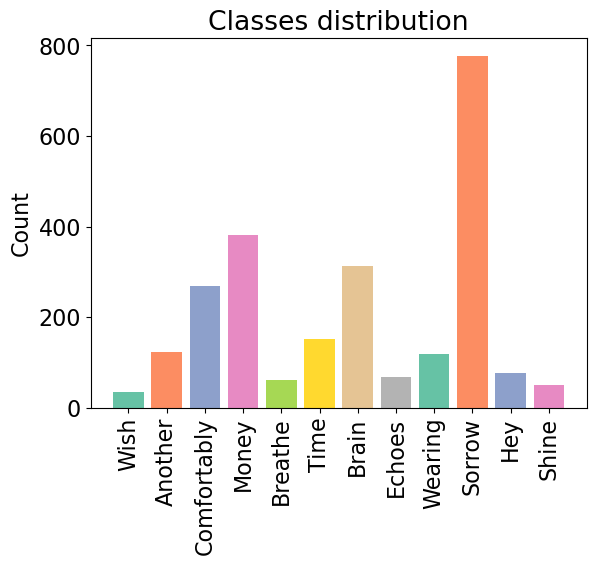

In [7]:
# Vertical bar plot of the classes distribution in y
plt.title('Classes distribution')
plt.bar(label_mapping.keys(), np.bincount(y), color = matplotlib.colormaps['Set2'].colors)
plt.xticks(rotation=90)
plt.ylabel('Count')
plt.show()

#### Support functions

In [8]:
def plot_history(history):
    best_epoch = np.argmax(history['val_accuracy'])
    plt.figure(figsize=(17,4))
    plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
    plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
    plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
    plt.title('Categorical Crossentropy')
    plt.legend()
    plt.grid(alpha=.3)
    plt.show()

    plt.figure(figsize=(17,4))
    plt.plot(history['accuracy'], label='Training accuracy', alpha=.8, color='#ff7f0e')
    plt.plot(history['val_accuracy'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
    plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
    plt.title('Accuracy')
    plt.legend()
    plt.grid(alpha=.3)
    plt.show()

    plt.figure(figsize=(17,4))
    plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
    plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
    plt.legend()
    plt.grid(alpha=.3)
    plt.show()

def plot_cm(model):
    # Predict the test set with the LSTM
    predictions = model.predict(X_test)
    predictions.shape

    # Compute the confusion matrix
    cm = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))

    # Compute the classification metrics
    accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))
    precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
    recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
    f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
    print('Accuracy:',accuracy.round(4))
    print('Precision:',precision.round(4))
    print('Recall:',recall.round(4))
    print('F1:',f1.round(4))

    # Plot the confusion matrix
    plt.figure(figsize=(10,8))
    sns.heatmap(cm.T, cmap='Blues', xticklabels=list(label_mapping.keys()), yticklabels=list(label_mapping.keys()), annot=True, fmt="d")
    plt.xlabel('True labels')
    plt.ylabel('Predicted labels')
    plt.show()

#### Vanilla LSTM

In [9]:
def build_LSTM_classifier(input_shape, classes):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    # Feature extractor
    lstm = tfkl.LSTM(256, return_sequences=True)(input_layer)
    lstm = tfkl.LSTM(256, return_sequences=True)(lstm)
    lstm = tfkl.LSTM(256)(lstm)
    dropout = tfkl.Dropout(.5, seed=seed)(lstm)

    # Classifier
    output_layer = tfkl.Dense(classes, activation='softmax')(dropout)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='vanilla_model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

In [10]:
model = build_LSTM_classifier(input_shape, classes)
model.summary()

Model: "vanilla_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 36, 6)]           0         
                                                                 
 lstm (LSTM)                 (None, 36, 256)           269312    
                                                                 
 lstm_1 (LSTM)               (None, 36, 256)           525312    
                                                                 
 lstm_2 (LSTM)               (None, 256)               525312    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 12)                3084      
                                                                 
Total params: 1,323,020
Trainable params: 1,323,020
N

Epoch 1/200
17/17 [==============================] - 13s 459ms/step - loss: 2.0790 - accuracy: 0.1914 - val_loss: 1.7528 - val_accuracy: 0.3014 - lr: 0.0010
Epoch 2/200
17/17 [==============================] - 6s 375ms/step - loss: 1.5600 - accuracy: 0.3716 - val_loss: 1.6187 - val_accuracy: 0.3781 - lr: 0.0010
Epoch 3/200
17/17 [==============================] - 8s 453ms/step - loss: 1.3036 - accuracy: 0.4220 - val_loss: 1.4832 - val_accuracy: 0.3890 - lr: 0.0010
Epoch 4/200
17/17 [==============================] - 14s 873ms/step - loss: 1.1174 - accuracy: 0.4578 - val_loss: 1.5417 - val_accuracy: 0.3781 - lr: 0.0010
Epoch 5/200
17/17 [==============================] - 22s 1s/step - loss: 1.0642 - accuracy: 0.4811 - val_loss: 1.5245 - val_accuracy: 0.3808 - lr: 0.0010
Epoch 6/200
17/17 [==============================] - 22s 1s/step - loss: 0.9479 - accuracy: 0.5165 - val_loss: 1.4309 - val_accuracy: 0.4658 - lr: 0.0010
Epoch 7/200
17/17 [==============================] - 22s 1s/step -

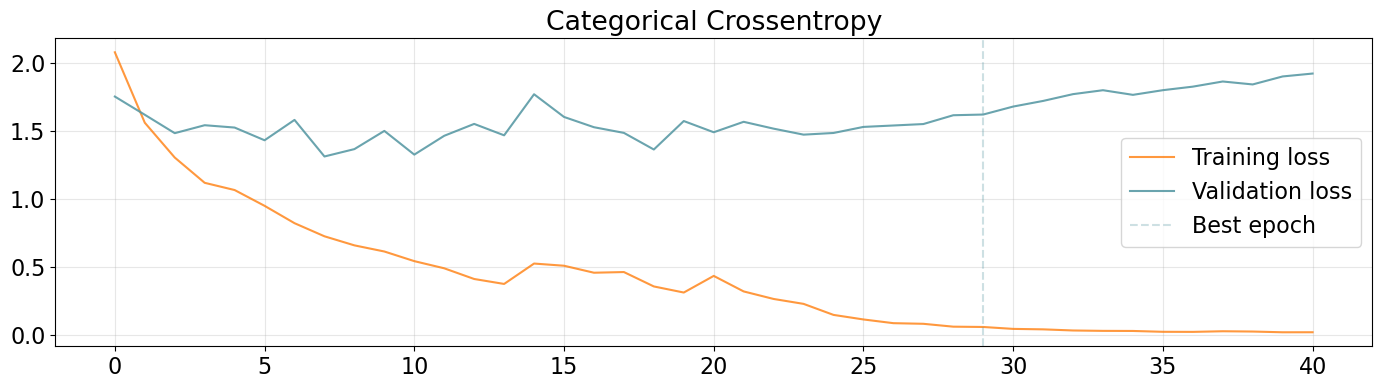

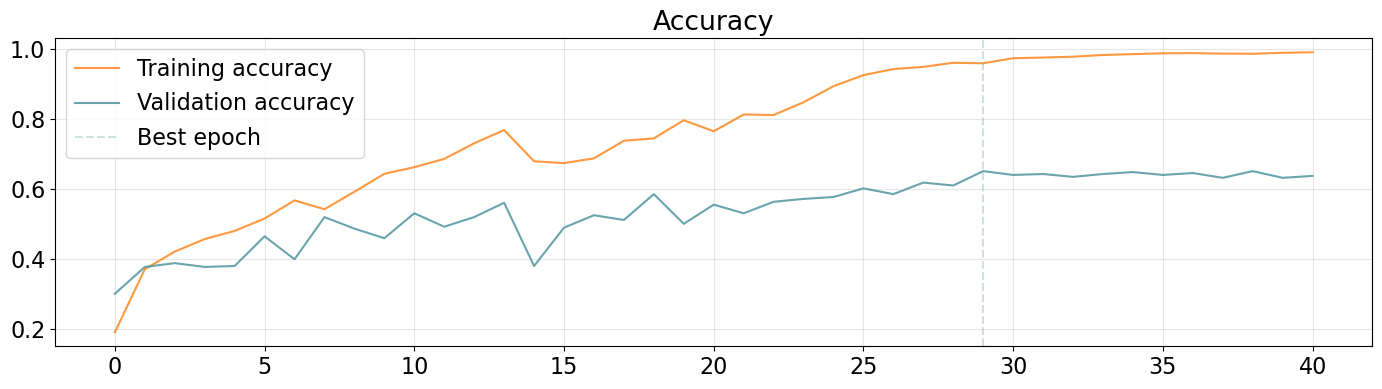

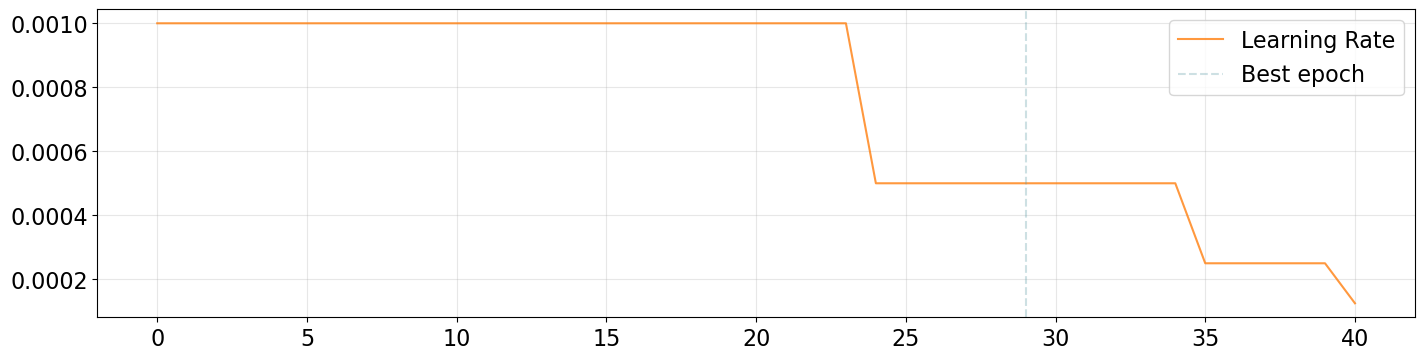

12/12 [==============================] - 3s 66ms/step
Accuracy: 0.6521
Precision: 0.5987
Recall: 0.5597
F1: 0.5717


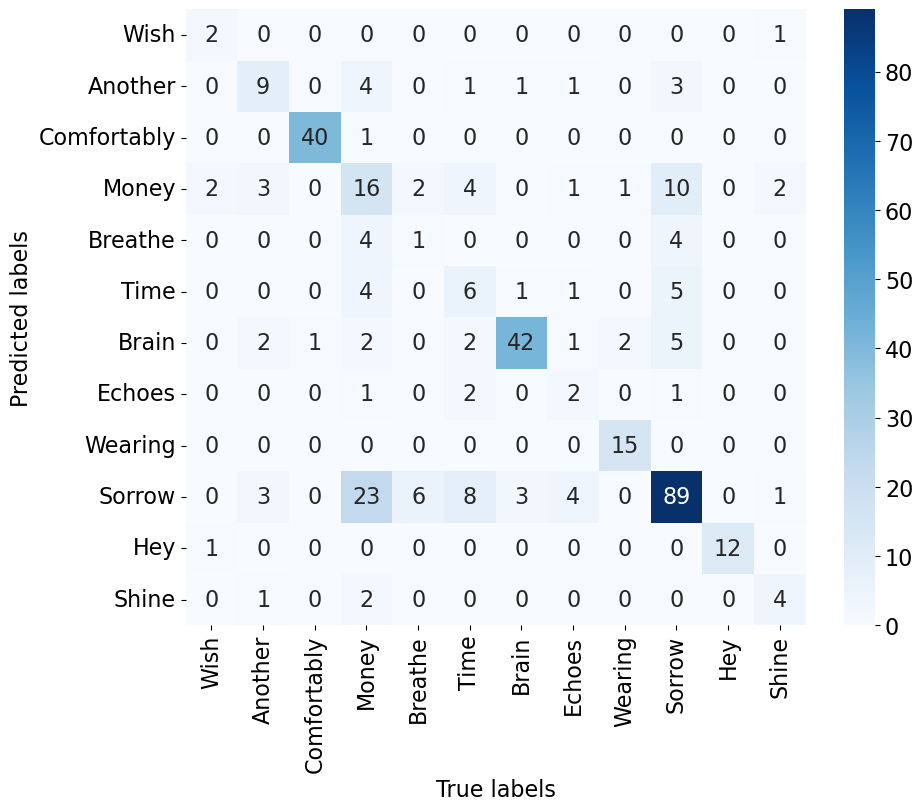

In [11]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = (X_test, y_test),
    class_weight = class_weights,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=11, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=5, factor=0.5, min_lr=1e-5)
    ]
).history

# Plot results
plot_history(history)
plot_cm(model)

#### Bidirectional LSTM
Since we have to perform speech recognition it is probably useless to consider a bidirectional architecture, but we can still try to use it

In [12]:
def build_BiLSTM_classifier(input_shape, classes):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    # Feature extractor
    bilstm = tfkl.Bidirectional(tfkl.LSTM(256, return_sequences=True))(input_layer)
    bilstm = tfkl.Bidirectional(tfkl.LSTM(256, return_sequences=True))(bilstm)
    bilstm = tfkl.Bidirectional(tfkl.LSTM(256))(bilstm)
    dropout = tfkl.Dropout(.5, seed=seed)(bilstm)

    # Classifier
    output_layer = tfkl.Dense(classes, activation='softmax')(dropout)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='bd_model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

In [13]:
model = build_BiLSTM_classifier(input_shape, classes)
model.summary()

Model: "bd_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 36, 6)]           0         
                                                                 
 bidirectional (Bidirectiona  (None, 36, 512)          538624    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 36, 512)          1574912   
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 512)              1574912   
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                          

Epoch 1/200
17/17 [==============================] - 20s 723ms/step - loss: 1.9460 - accuracy: 0.2161 - val_loss: 1.6295 - val_accuracy: 0.3507 - lr: 0.0010
Epoch 2/200
17/17 [==============================] - 10s 602ms/step - loss: 1.2930 - accuracy: 0.4293 - val_loss: 1.6955 - val_accuracy: 0.3589 - lr: 0.0010
Epoch 3/200
17/17 [==============================] - 11s 626ms/step - loss: 1.0663 - accuracy: 0.4889 - val_loss: 1.3240 - val_accuracy: 0.4849 - lr: 0.0010
Epoch 4/200
17/17 [==============================] - 10s 601ms/step - loss: 0.8852 - accuracy: 0.5276 - val_loss: 1.3406 - val_accuracy: 0.4603 - lr: 0.0010
Epoch 5/200
17/17 [==============================] - 10s 593ms/step - loss: 0.7368 - accuracy: 0.5795 - val_loss: 1.2847 - val_accuracy: 0.4932 - lr: 0.0010
Epoch 6/200
17/17 [==============================] - 10s 586ms/step - loss: 0.6398 - accuracy: 0.6221 - val_loss: 1.2992 - val_accuracy: 0.4904 - lr: 0.0010
Epoch 7/200
17/17 [==============================] - 10s 5

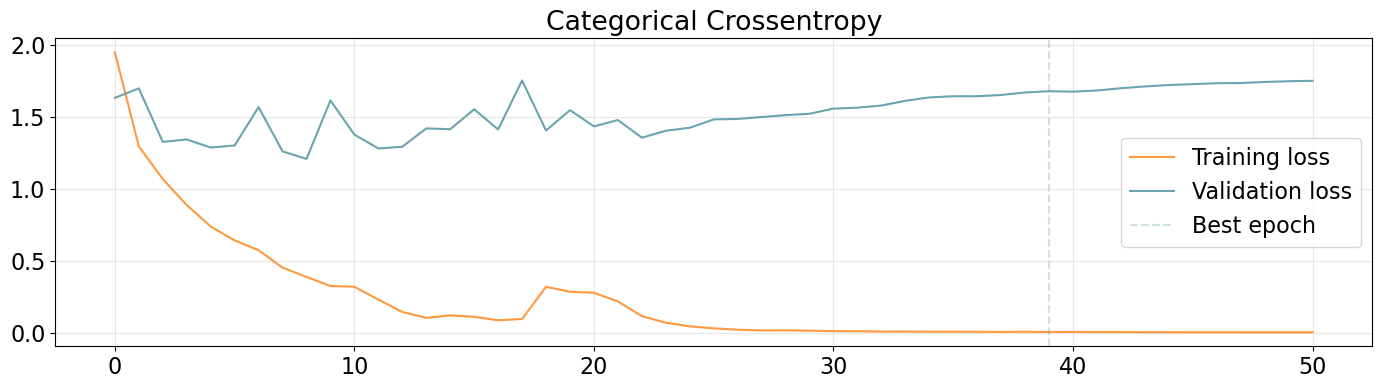

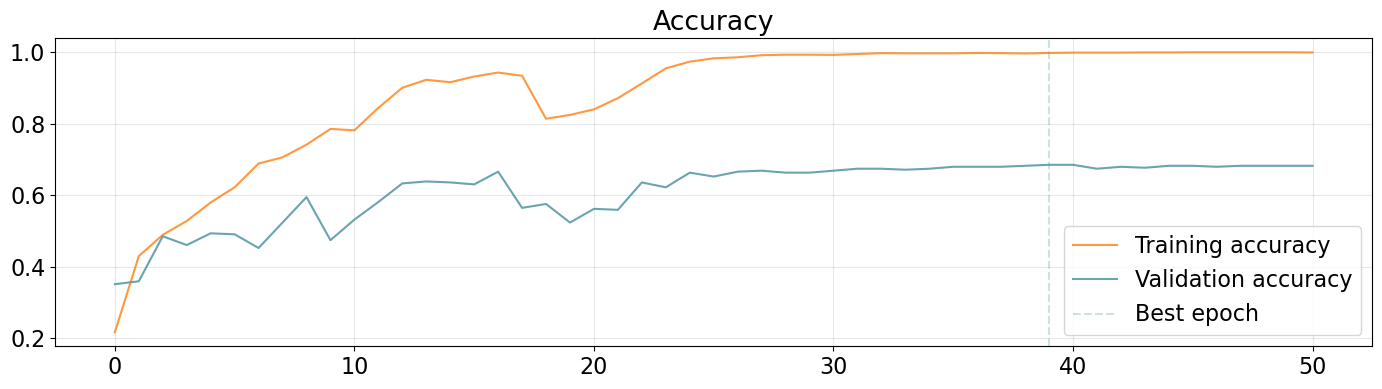

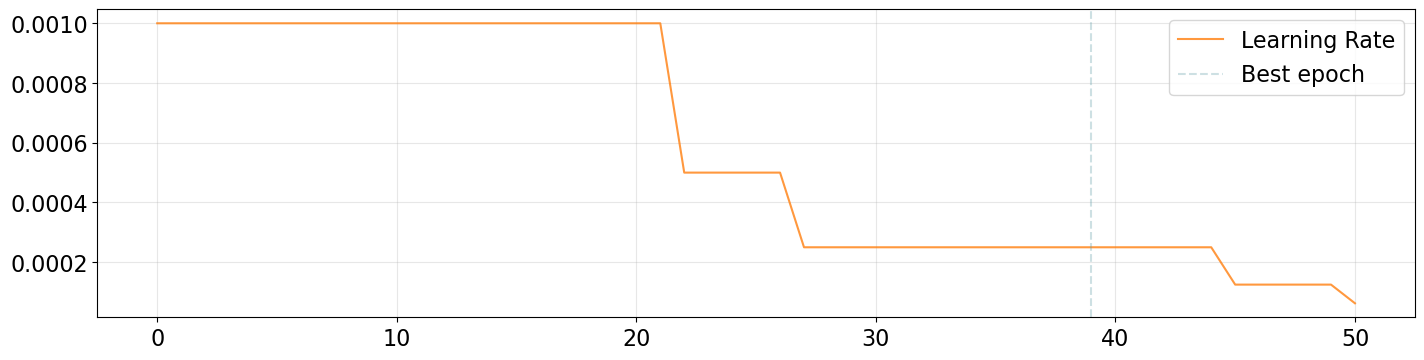

12/12 [==============================] - 3s 66ms/step
Accuracy: 0.6849
Precision: 0.629
Recall: 0.5811
F1: 0.5961


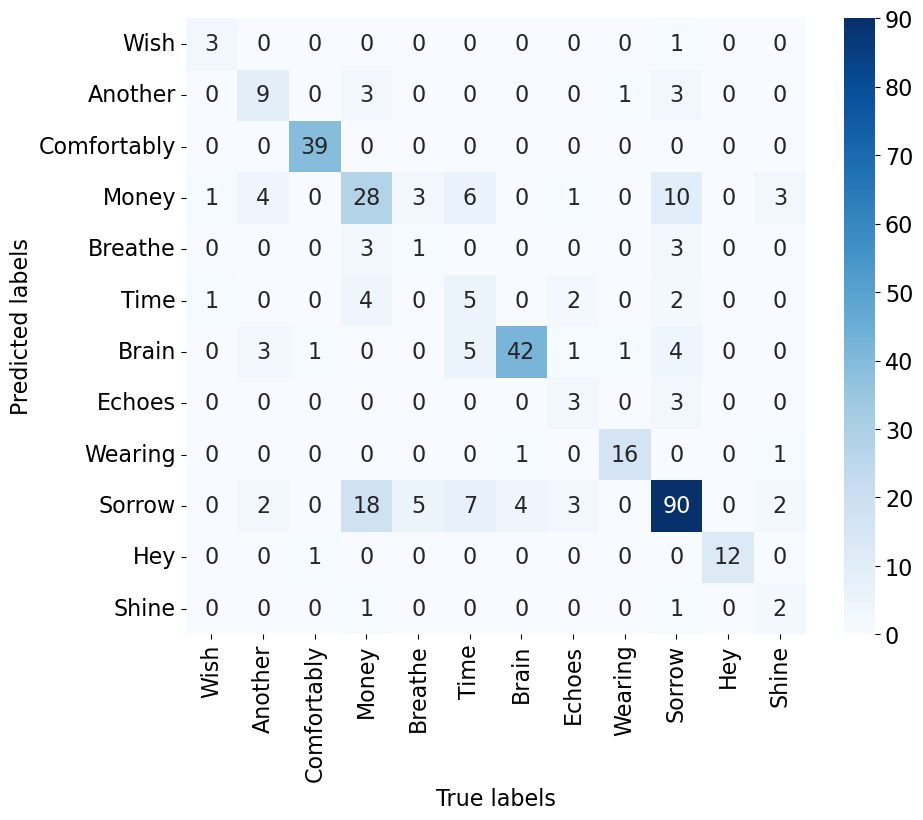

In [14]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = (X_test, y_test),
    class_weight = class_weights,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=11, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=5, factor=0.5, min_lr=1e-5)
    ]
).history

# Plot results
plot_history(history)
plot_cm(model)

#### Convolutional network

In [15]:
def build_1DCNN_classifier(input_shape, classes):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    # Feature extractor
    cnn = tfkl.Conv1D(256,3,padding='same',activation='relu')(input_layer)
    cnn = tfkl.MaxPooling1D()(cnn)
    cnn = tfkl.Conv1D(256,3,padding='same',activation='relu')(cnn)
    gap = tfkl.GlobalAveragePooling1D()(cnn)
    dropout = tfkl.Dropout(.5, seed=seed)(gap)

    # Classifier
    output_layer = tfkl.Dense(classes, activation='softmax')(dropout)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='cnn_model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

In [16]:
model = build_1DCNN_classifier(input_shape, classes)
model.summary()

Model: "cnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 36, 6)]           0         
                                                                 
 conv1d (Conv1D)             (None, 36, 256)           4864      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 18, 256)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 18, 256)           196864    
                                                                 
 global_average_pooling1d (G  (None, 256)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout_2 (Dropout)         (None, 256)               0 

Epoch 1/200
17/17 [==============================] - 1s 31ms/step - loss: 62.7407 - accuracy: 0.0678 - val_loss: 21.7316 - val_accuracy: 0.1452 - lr: 0.0010
Epoch 2/200
17/17 [==============================] - 0s 20ms/step - loss: 45.0316 - accuracy: 0.0959 - val_loss: 37.5079 - val_accuracy: 0.0466 - lr: 0.0010
Epoch 3/200
17/17 [==============================] - 0s 18ms/step - loss: 33.6406 - accuracy: 0.0722 - val_loss: 13.9898 - val_accuracy: 0.0822 - lr: 0.0010
Epoch 4/200
17/17 [==============================] - 0s 18ms/step - loss: 27.7850 - accuracy: 0.0930 - val_loss: 10.5014 - val_accuracy: 0.0849 - lr: 0.0010
Epoch 5/200
17/17 [==============================] - 0s 17ms/step - loss: 10.9011 - accuracy: 0.0988 - val_loss: 5.6595 - val_accuracy: 0.1562 - lr: 0.0010
Epoch 6/200
17/17 [==============================] - 0s 18ms/step - loss: 14.1864 - accuracy: 0.1376 - val_loss: 5.1095 - val_accuracy: 0.1178 - lr: 0.0010
Epoch 7/200
17/17 [==============================] - 0s 18ms

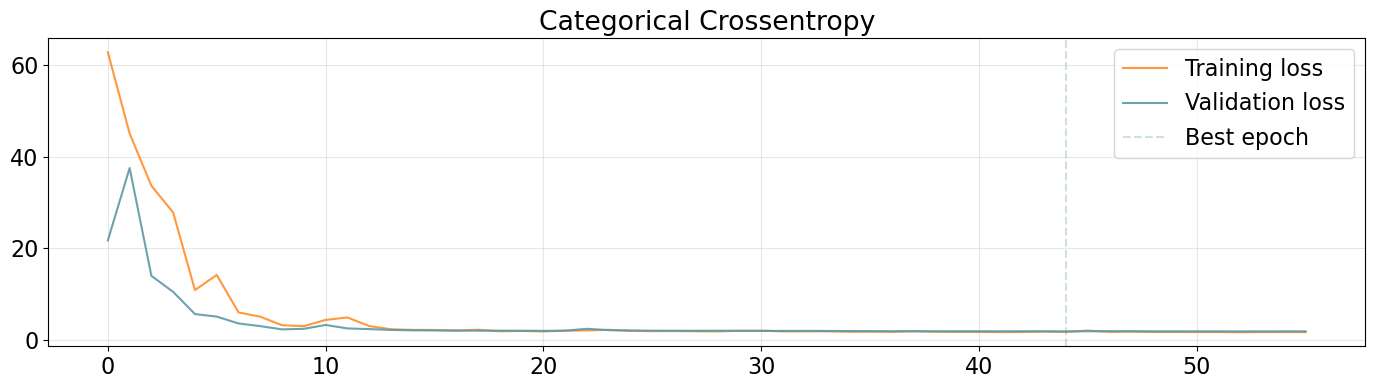

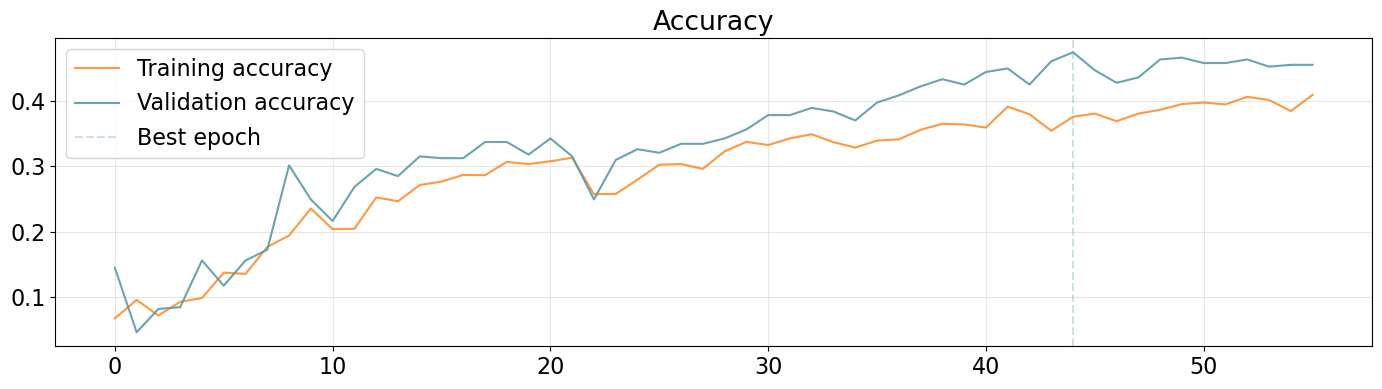

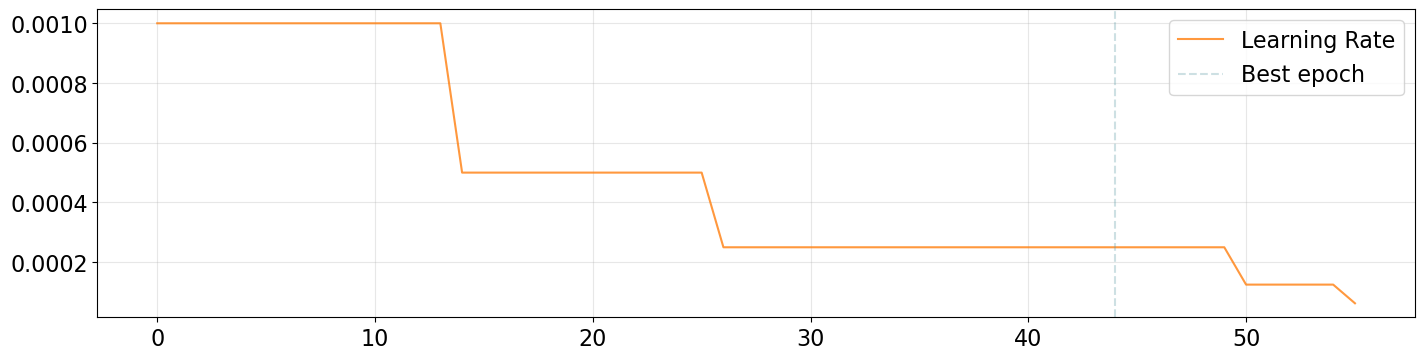

12/12 [==============================] - 1s 3ms/step
Accuracy: 0.474
Precision: 0.4319
Recall: 0.4905
F1: 0.4273


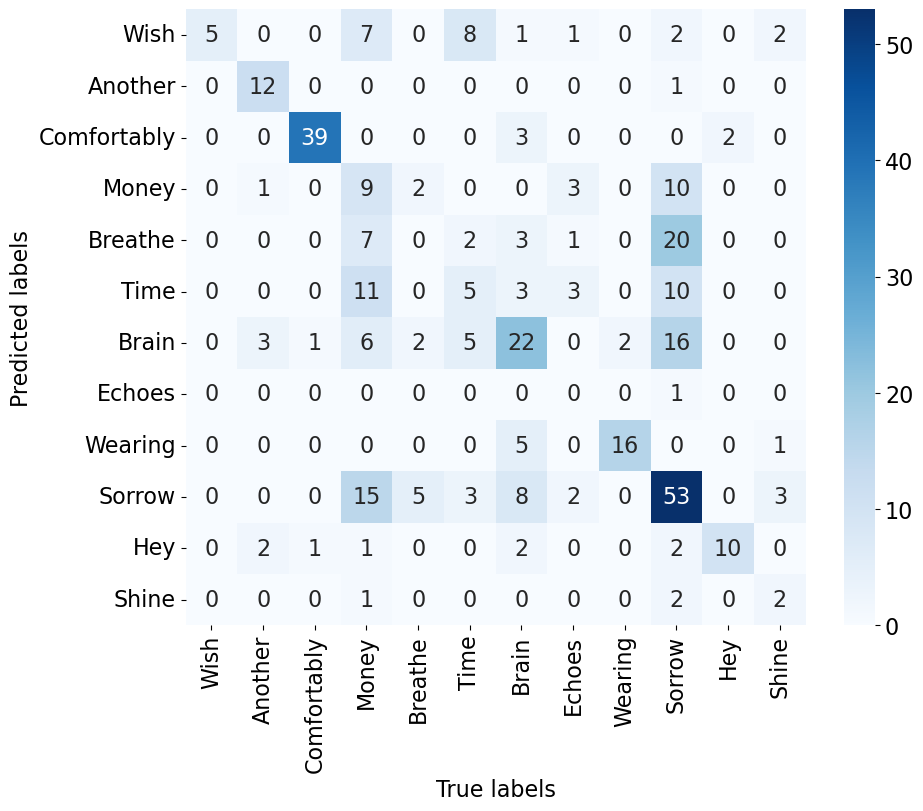

In [17]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = (X_test, y_test),
    class_weight = class_weights,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=11, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=5, factor=0.5, min_lr=1e-5)
    ]
).history

# Plot results
plot_history(history)
plot_cm(model)